<a href="https://colab.research.google.com/github/Andres8bit/Machine-Learning/blob/main/GoogleLeNet_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import cv2 
import numpy as np 
import keras
import math
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [17]:
def inception_layer(x,filters_1x1, filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool,name=None):
  # Functional API Layer Construction:
  conv_1x1 = Conv2D(filters=filters_1x1,kernel_size=(1,1),padding='same',
                    kernel_initializer=kernel_init,bias_initializer=bias_init)(x)
  
  # 3x3 route -> 1x1 reduce to 3x3 Convolution:
    #  1x1 Reduce/Bottleneck layer:
  pre_conv_3x3 = Conv2D(filters=filters_3x3_reduce,kernel_size=(1,1),
                        padding='same',activation='relu',
                        kernel_initializer=kernel_init,bias_initializer=bias_init)(x)
    # 3x3 Convolutional Layer:
  conv_3x3 = Conv2D(filters_3x3,kernel_size=(3,3),padding='same',activation='relu'
       ,kernel_initializer=kernel_init,bias_initializer=bias_init)(pre_conv_3x3)

  # 5x5 route -> 1x1 reduce to 5x5 Convolution:
    # 1x1 Reduce/BottelNeck Layer:
  pre_conv_5x5 = Conv2D(filters_5x5,kernel_size=(1,1),padding='same',activation='relu'
          ,kernel_initializer=kernel_init,bias_initializer=bias_init)(x)
    # 5x5 convolutional Layer:
  conv_5x5 = Conv2D(filters_5x5,kernel_size=(5,5),padding='same',activation='relu',
                    kernel_initializer=kernel_init,bias_initializer=bias_init)(pre_conv_5x5)
  
  # Pooling Route -> Pooling Layer to 1x1 Reduce:
    # 2D Max Pooling Layer:
  pool_route = MaxPool2D((3,3),strides=(1,1),padding='same')(x)
    # 1x1 Convolutional layer:
  pool_route = Conv2D(filters_pool,(1,1),padding='same',activation='relu',
                      kernel_initializer=kernel_init,bias_initializer=bias_init)(pool_route)
  
  # OutPut Layer -> Concatenate all Inception layers:
  output = concatenate([conv_1x1,conv_3x3,conv_5x5,pool_route],axis=3,name=name)

  return output



In [10]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [23]:
# Model Construction:
  # Input Layer -> shape = 224 x 224 x 3:
input_layer = Input(shape=(224,224,3))

  # Bottom Layer of Model:
    # 7x7 Convolutional Layer:
x = Conv2D(64,(7,7),padding='same',strides=(2,2),name='conv_1_7x7/2',
           kernel_initializer=kernel_init,bias_initializer=bias_init) (input_layer)
    # Max Pooling Layer:
x = MaxPool2D((3,3),padding='same',strides=(2,2),name='max_pool_1_3x3/2')(x)
    # BatchNormalization Layer:
x = BatchNormalization()(x)
    # 1x1 Convolutional Layer:
x = Conv2D(64,(1,1),padding='same',strides=(1,1),activation='relu')(x)
    # 3x3 Convolutional Layer:
x = Conv2D(192,(3,3),padding='same',strides=(1,1),activation='relu')(x)
    # BatchNormalization:
x = BatchNormalization()(x)
    # MaxPooling Layer:
x = MaxPool2D((3,3),padding='same',strides=(2,2))(x)

  # 1st Inception Block:
x = inception_layer(x,filters_1x1=64,filters_3x3_reduce=96,filters_3x3=128,
                    filters_5x5_reduce=16,filters_5x5=32,filters_pool=32,
                    name='inception_3a')
  # 2nd Inception Block:
x = inception_layer(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=192,
                    filters_5x5_reduce=32,filters_5x5=96,filters_pool=64,
                    name='inception_3b')
  # MaxPooling Layer:
x = MaxPool2D((3,3),padding='same',strides=(2,2))(x)
  # 3rd Inception Block:
x = inception_layer(x,filters_1x1=192,filters_3x3_reduce=96,filters_3x3=208,
                    filters_5x5_reduce=16,filters_5x5=48,filters_pool=64,
                    name='inception_4a')
  # 4th Inception Block:
x = inception_layer(x,filters_1x1=160,filters_3x3_reduce=112,filters_3x3=224,
                    filters_5x5_reduce=24,filters_5x5=64,filters_pool=64,
                    name='inception_4b')
  # 5th Inception Block:
x = inception_layer(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=256,
                    filters_5x5_reduce=24,filters_5x5=64,filters_pool=64,
                    name='inception_4c')
  # 6th Inception Block:
x = inception_layer(x,filters_1x1=112,filters_3x3_reduce=144,filters_3x3=288,
                    filters_5x5_reduce=32,filters_5x5=64,filters_pool=64,
                    name='inception_4d')
  # 7th Inception Block:
x = inception_layer(x,filters_1x1=256,filters_3x3_reduce=160,filters_3x3=320,
                    filters_5x5_reduce=32,filters_5x5=128,filters_pool=128,
                    name='inception_4e')
  # MaxPooling Layer:
x = MaxPool2D((3,3),padding='same',strides=(2,2),name='max_pool_4_3x3/2')(x)

  # 8th Inception Block:
x = inception_layer(x,filters_1x1=256,filters_3x3_reduce=160,filters_3x3=320,
                    filters_5x5_reduce=32,filters_5x5=128,filters_pool=128,
                    name='inception_5a')
  # 9th Inception Block:
x = inception_layer(x,filters_1x1=384,filters_3x3_reduce=192,filters_3x3=384,
                    filters_5x5_reduce=48,filters_5x5=128,filters_pool=128,
                    name='inception_5b')

  # Classification Layer:
    # Average Pooling:
x = AveragePooling2D(pool_size=(7,7),strides=1,padding='valid')(x)
    # Dropout Layer 40% probability:
x = Dropout(0.4)(x)
    # Final Dense Softmax Layer:
x = Dense(10,activation='softmax',name='output')(x)


In [26]:
model = Model(input_layer, [x], name='InceptionNet')

In [27]:
model.summary()

Model: "InceptionNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_12[0][0]                   
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 56, 56, 64)   256         max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

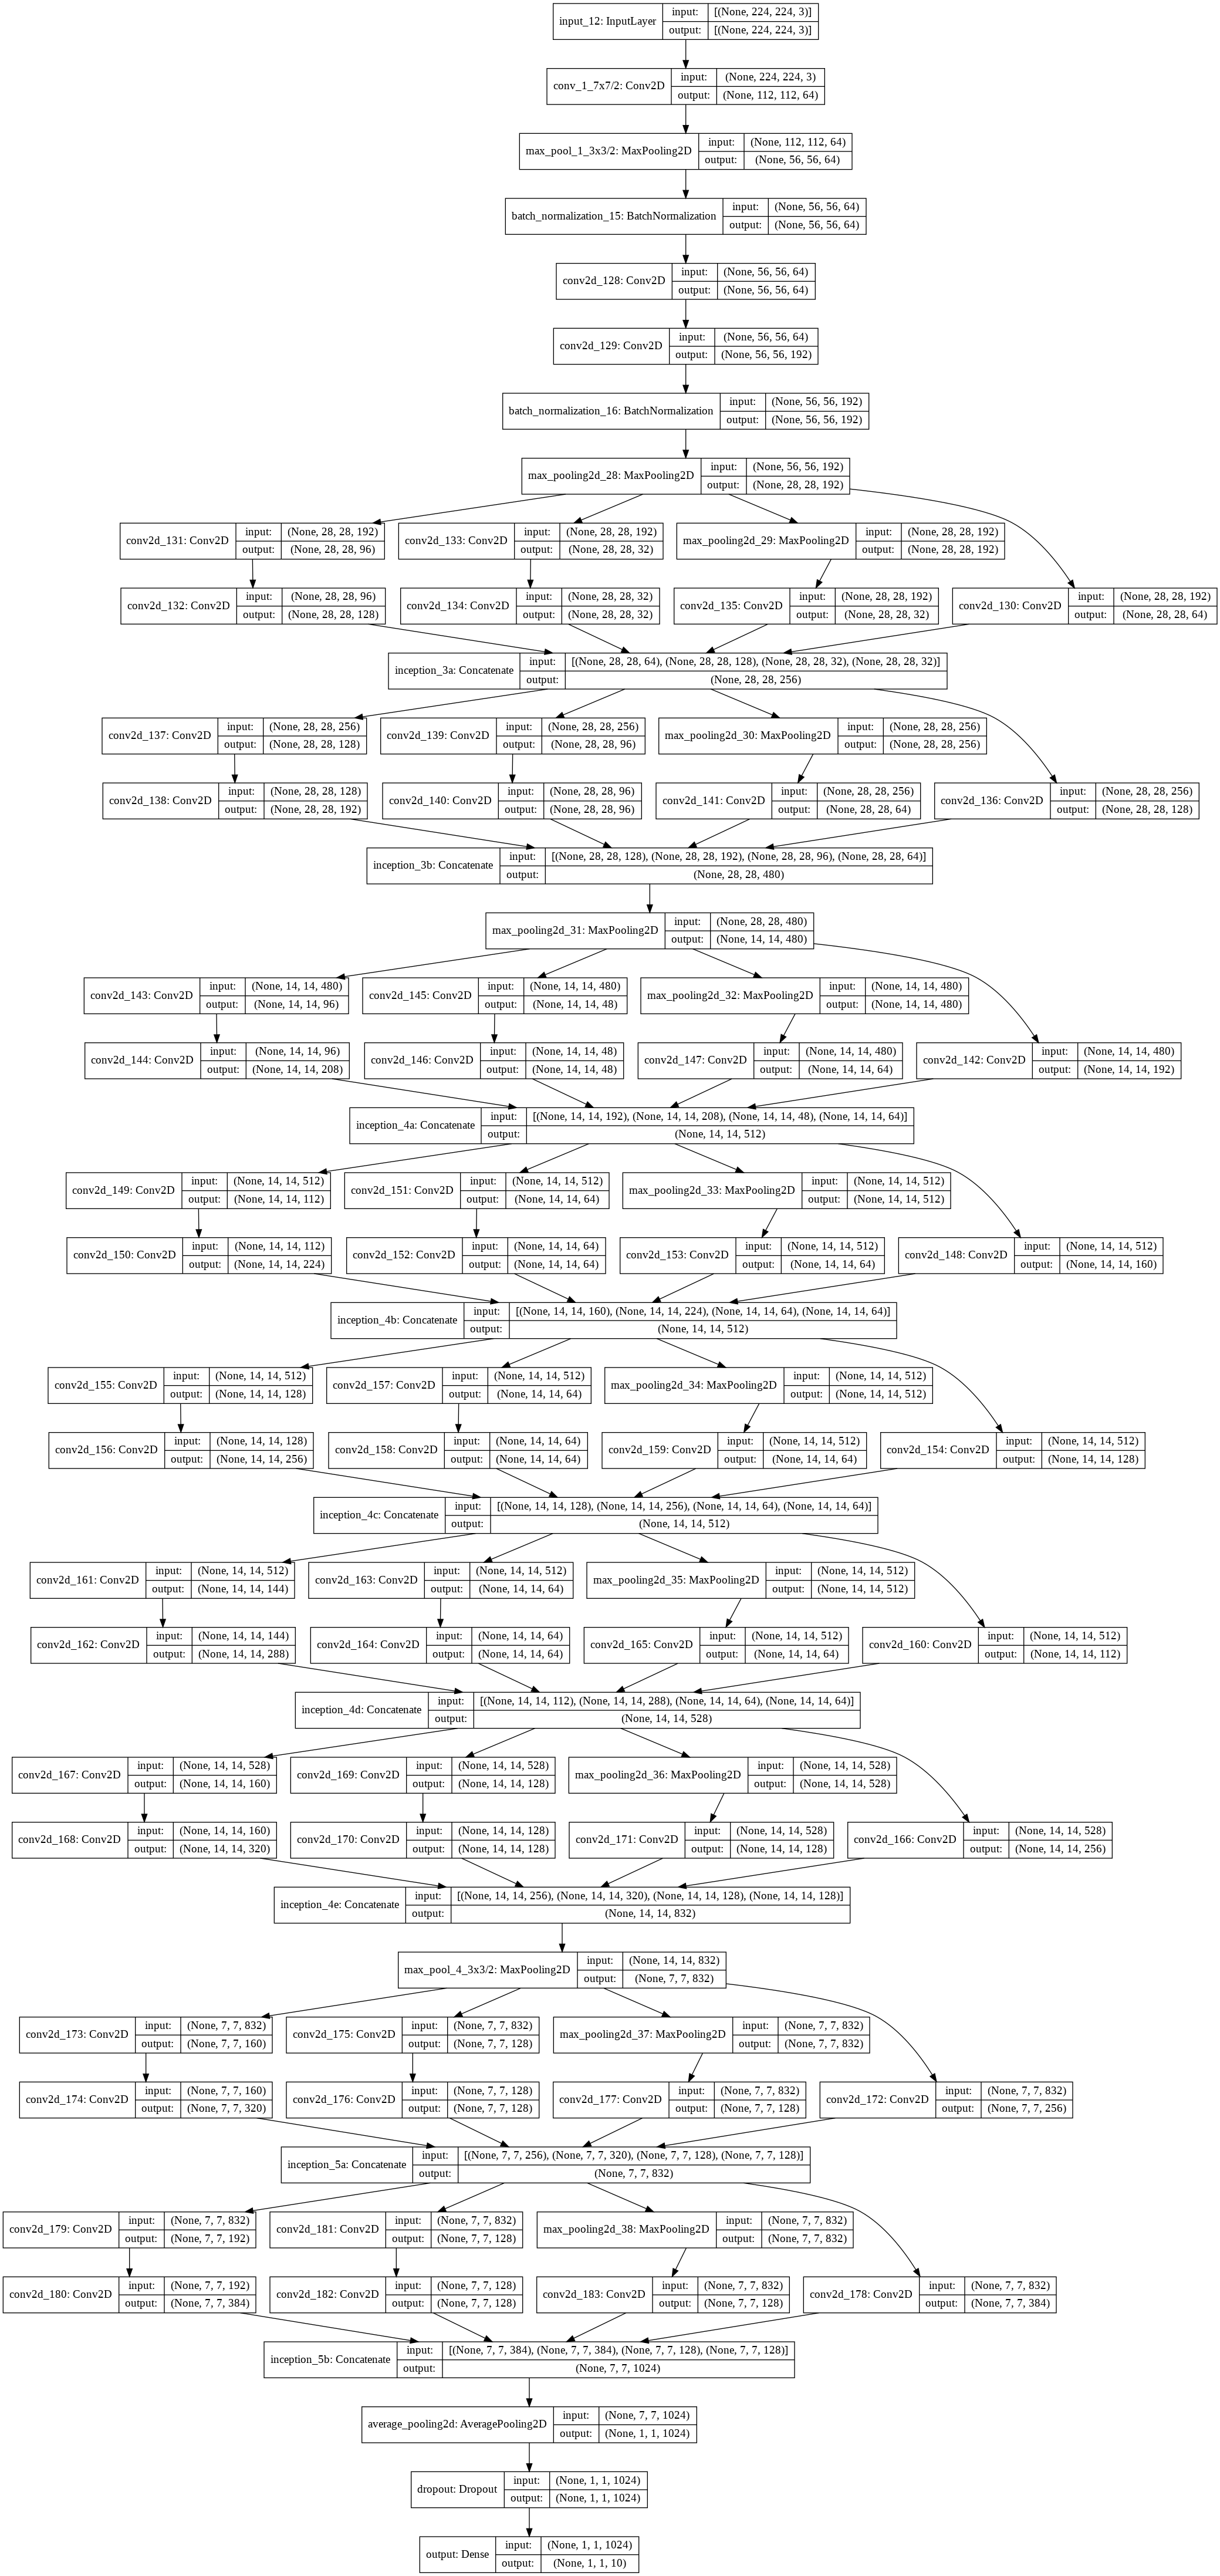

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)